In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, r2_score
import matplotlib.pyplot as plt
import os

try:
    from ipywidgets import FloatProgress
    from IPython.display import display
    USE_IPYWIDGETS = True
except ImportError:
    print("ipywidgets not found. Progress bars will not be displayed.")
    USE_IPYWIDGETS = False


try:
    import cupy as cp
    # Set default backend for numpy-like functions
    cp.cuda.set_allocator(cp.cuda.MemoryPool().malloc)
    print("CuPy is available and will be used for LWT operations.")
    USE_CUPY = True
except ImportError:
    print("CuPy not found. Falling back to NumPy for LWT operations.")
    cp = np # Alias cp to n

CuPy is available and will be used for LWT operations.


In [6]:
# --- Custom LWT Class (Extended with Linear Interpolation Wavelet, CuPy enabled) ---
from distributed import progress


class LWT:
    """
    A Python class for performing Lifting Wavelet Transform (LWT)
    and its inverse for multi-dimensional, multi-level continuous data,
    using CuPy for GPU acceleration if available.

    This version includes Haar and a 'linear_interp' wavelet (simplified CDF 2,2).
    Implementing other complex wavelets from scratch (like full Daubechies, Symlets, Coiflets,
    Biorthogonal, Meyer) is extremely complex and not included here.
    """

    def __init__(self, wavelet_name="haar"):
        """
        Initializes the LWT class.

        Args:
            wavelet_name (str): The name of the wavelet to use.
                                Supported: "haar", "linear_interp".
        """
        self.wavelet_name = wavelet_name.lower()
        self.cp_module = cp # Alias CuPy or NumPy module
        self._load_wavelet_functions()

    def _load_wavelet_functions(self):
        """
        Loads the specific predict and update functions based on the chosen wavelet.
        """
        if self.wavelet_name == "haar":
            self._predict_func = self._haar_predict_transform
            self._update_func = self._haar_update_transform
            self._inverse_update_func = self._haar_inverse_update_transform
            self._inverse_predict_func = self._haar_inverse_predict_transform
        elif self.wavelet_name == "linear_interp":
            self._predict_func = self._linear_interp_predict_transform
            self._update_func = self._linear_interp_update_transform
            self._inverse_update_func = self._linear_interp_inverse_update_transform
            self._inverse_predict_func = self._linear_interp_inverse_predict_transform
        else:
            raise NotImplementedError(
                f"Wavelet '{self.wavelet_name}' is not implemented from scratch in this version. "
                "Supported wavelets: 'haar', 'linear_interp'."
                "Implementing Daubechies, Symlets, Coiflets, Biorthogonal, Meyer from scratch "
                "is highly complex and beyond the scope of this example."
            )

    def _split_1d(self, data):
        """
        Splits a 1D array into even and odd indexed samples.
        Handles odd lengths by padding the last element.

        Args:
            data (cp.ndarray): A 1D CuPy/NumPy array.

        Returns:
            tuple: (even_samples, odd_samples, original_length)
        """
        original_length = len(data)
        if original_length % 2 != 0:
            data = self.cp_module.append(data, data[-1]) # Pad by duplicating last element
        
        even = data[::2].astype(self.cp_module.float64)
        odd = data[1::2].astype(self.cp_module.float64)
        return even, odd, original_length

    def _merge_1d(self, even, odd, original_length):
        """
        Merges even and odd samples back into a 1D array.
        Removes padding if it was added during splitting.

        Args:
            even (cp.ndarray): Array of even-indexed samples.
            odd (cp.ndarray): Array of odd-indexed samples.
            original_length (int): The original length of the array before padding.

        Returns:
            cp.ndarray: The reconstructed 1D array.
        """
        merged_length = len(even) + len(odd)
        reconstructed = self.cp_module.empty(merged_length, dtype=even.dtype)

        reconstructed[::2] = even
        reconstructed[1::2] = odd

        # Remove padding if it was added
        if merged_length != original_length:
            reconstructed = reconstructed[:original_length]
        return reconstructed

    # --- Haar Wavelet Functions (Using self.cp_module for CuPy/NumPy compatibility) ---
    def _haar_predict_transform(self, odd_data, even_data):
        """Haar wavelet prediction step: d = odd - even."""
        return odd_data - even_data

    def _haar_update_transform(self, even_data, detail_data):
        """Haar wavelet update step: a = even + detail / 2."""
        return even_data + detail_data / 2

    def _haar_inverse_update_transform(self, approx_data, detail_data):
        """Haar wavelet inverse update step: even = approx - detail / 2."""
        return approx_data - detail_data / 2

    def _haar_inverse_predict_transform(self, detail_data, even_data):
        """Haar wavelet inverse prediction step: odd = detail + even."""
        return detail_data + even_data

    # --- Linear Interpolation Wavelet Functions (CuPy compatible) ---
    def _linear_interp_predict_transform(self, odd_data, even_data):
        """
        Linear interpolation wavelet prediction step.
        d_i = odd[i] - (even[i] + even[i+1]) / 2.
        Handles boundaries using symmetric extension via cp.pad.
        """
        even_padded = self.cp_module.pad(even_data, (0, 1), mode='symmetric')
        predicted_values = (even_padded[:-1] + even_padded[1:]) / 2
        return odd_data - predicted_values

    def _linear_interp_update_transform(self, even_data, detail_data):
        """
        Linear interpolation wavelet update step.
        a_i = even[i] + (d[i-1] + d[i]) / 4.
        Handles boundaries using symmetric extension via cp.pad.
        """
        detail_padded = self.cp_module.pad(detail_data, (1, 0), mode='symmetric')
        updated_values = (detail_padded[:-1] + detail_padded[1:]) / 4
        return even_data + updated_values

    def _linear_interp_inverse_update_transform(self, approx_data, detail_data):
        """
        Inverse of linear interpolation wavelet update step.
        even[i] = approx[i] - (d[i-1] + d[i]) / 4.
        """
        detail_padded = self.cp_module.pad(detail_data, (1, 0), mode='symmetric')
        updated_values = (detail_padded[:-1] + detail_padded[1:]) / 4
        return approx_data - updated_values

    def _linear_interp_inverse_predict_transform(self, detail_data, even_data):
        """
        Inverse of linear interpolation wavelet prediction step.
        odd[i] = detail[i] + (even[i] + even[i+1]) / 2.
        """
        even_padded = self.cp_module.pad(even_data, (0, 1), mode='symmetric')
        predicted_values = (even_padded[:-1] + even_padded[1:]) / 2
        return detail_data + predicted_values


    def _apply_1d_forward_step(self, data):
        """
        Applies one level of 1D LWT (split, predict, update) using the selected wavelet.
        Operates on CuPy/NumPy 1D arrays.

        Args:
            data (cp.ndarray): A 1D CuPy/NumPy array.

        Returns:
            tuple: (approximation_coeffs, detail_coeffs, original_length)
        """
        even, odd, original_length = self._split_1d(data)
        
        detail_coeffs = self._predict_func(odd, even)
        approximation_coeffs = self._update_func(even, detail_coeffs)
        
        return approximation_coeffs, detail_coeffs, original_length

    def _apply_1d_inverse_step(self, approx_coeffs, detail_coeffs, original_length):
        """
        Applies one level of 1D inverse LWT (inverse update, inverse predict, merge)
        using the selected wavelet. Operates on CuPy/NumPy 1D arrays.

        Args:
            approx_coeffs (cp.ndarray): Approximation coefficients.
            detail_coeffs (cp.ndarray): Detail coefficients.
            original_length (int): The original length of the array before padding.

        Returns:
            cp.ndarray: The reconstructed 1D array.
        """
        even = self._inverse_update_func(approx_coeffs, detail_coeffs)
        odd = self._inverse_predict_func(detail_coeffs, even)
        reconstructed = self._merge_1d(even, odd, original_length)
        return reconstructed

    def transform(self, data, levels=1):
        """
        Performs multi-dimensional, multi-level Lifting Wavelet Transform (LWT)
        on continuous data using a separable approach, optimized for CuPy.

        Args:
            data (cp.ndarray): The input N-dimensional data.
                               Should be a CuPy/NumPy array of float type.
            levels (int): The number of decomposition levels. Must be >= 1.

        Returns:
            tuple: (final_approx_coeffs, detail_coeffs_by_level, original_lengths_info)
                - final_approx_coeffs (cp.ndarray): The approximation coefficients
                                                    at the coarsest (final) level.
                - detail_coeffs_by_level (list): A list of dictionaries, one for each level.
                                                 Each dictionary contains detail subbands for that level.
                                                 Keys are tuples indicating subband type (e.g., ('A', 'D') for LH).
                - original_lengths_info (list): A list of lists. For each level, it stores the
                                                original lengths of each axis of the
                                                approximation coefficient array *before* padding.
                                                This is crucial for inverse transform.
        Raises:
            ValueError: If levels is less than 1.
        """
        if not isinstance(data, self.cp_module.ndarray):
            data = self.cp_module.asarray(data, dtype=self.cp_module.float64)
        if data.dtype not in [self.cp_module.float32, self.cp_module.float64]:
             data = data.astype(self.cp_module.float64)

        if levels < 1:
            raise ValueError("Number of decomposition levels must be at least 1.")

        current_approx = data
        all_detail_coeffs = []
        all_original_lengths_info = []

        num_dims = data.ndim

        for level in range(levels):
            # subbands_to_process: a dictionary of {key_tuple: cp.ndarray}
            # Initially, for a level, it starts with one subband: {('A',)*num_dims: current_approx}
            subbands_to_process = {('A',) * num_dims: current_approx}
            current_level_original_lengths = [None] * num_dims

            for axis_idx in range(num_dims):
                next_level_coeffs_along_axis = {}
                processed_this_axis_len_saved = False

                for key_tuple, subband_array in subbands_to_process.items():
                    if subband_array is None:
                        continue

                    # Store original length for this axis (only once per axis per level)
                    if not processed_this_axis_len_saved:
                        current_level_original_lengths[axis_idx] = subband_array.shape[axis_idx]
                        processed_this_axis_len_saved = True

                    # 1. Move target axis to the last position
                    arr_transposed = self.cp_module.moveaxis(subband_array, axis_idx, -1)
                    original_last_dim_len = arr_transposed.shape[-1]
                    
                    # 2. Reshape to (num_slices, length_of_axis) for batch processing of 1D transforms
                    num_slices = arr_transposed.size // original_last_dim_len
                    arr_reshaped_for_1d = arr_transposed.reshape(num_slices, original_last_dim_len)

                    # Determine the output length of a 1D transform (after potential padding in _split_1d)
                    temp_even, _, _ = self._split_1d(self.cp_module.empty(original_last_dim_len, dtype=arr_reshaped_for_1d.dtype))
                    len_after_1d_transform = len(temp_even) # approx and detail will have this length

                    approx_slices = self.cp_module.empty((num_slices, len_after_1d_transform), dtype=arr_reshaped_for_1d.dtype)
                    detail_slices = self.cp_module.empty((num_slices, len_after_1d_transform), dtype=arr_reshaped_for_1d.dtype)
                    
                    # 3. Apply 1D LWT to each "row" (slice) of this 2D array.
                    # This loop is still in Python but operates on CuPy arrays,
                    # minimizing host-device transfers per slice.
                    for i in range(num_slices):
                        approx_s, detail_s, _ = self._apply_1d_forward_step(arr_reshaped_for_1d[i])
                        approx_slices[i] = approx_s
                        detail_slices[i] = detail_s
                    
                    # 4. Reshape back and move axis to original position
                    new_shape_prefix = arr_transposed.shape[:-1] # Shape excluding the transformed last dim
                    
                    approx_reconstructed = self.cp_module.moveaxis(
                        approx_slices.reshape(new_shape_prefix + (len_after_1d_transform,)), -1, axis_idx
                    )
                    detail_reconstructed = self.cp_module.moveaxis(
                        detail_slices.reshape(new_shape_prefix + (len_after_1d_transform,)), -1, axis_idx
                    )

                    # Update the keys for the next axis's processing
                    next_level_coeffs_along_axis[key_tuple[:axis_idx] + ('A',) + key_tuple[axis_idx+1:]] = approx_reconstructed
                    next_level_coeffs_along_axis[key_tuple[:axis_idx] + ('D',) + key_tuple[axis_idx+1:]] = detail_reconstructed
                
                subbands_to_process = next_level_coeffs_along_axis
            
            # After processing all axes for this level, `subbands_to_process` contains all 2^num_dims subbands
            current_approx = subbands_to_process[('A',) * num_dims]
            current_level_details = {k: v for k, v in subbands_to_process.items() if k != ('A',) * num_dims}

            all_detail_coeffs.append(current_level_details)
            all_original_lengths_info.append(current_level_original_lengths)
            
        return current_approx, all_detail_coeffs, all_original_lengths_info

    def inverse_transform(self, final_approx_coeffs, detail_coeffs_by_level, original_lengths_info):
        """
        Performs the inverse multi-dimensional, multi-level LWT, optimized for CuPy.

        Args:
            final_approx_coeffs (cp.ndarray): The approximation coefficients
                                              at the coarsest (final) level.
            detail_coeffs_by_level (list): A list of dictionaries of detail subbands
                                           for each level, as returned by `transform`.
            original_lengths_info (list): A list of lists of original lengths for each axis
                                          at each level, as returned by `transform`.

        Returns:
            cp.ndarray: The reconstructed original N-dimensional data.
        Raises:
            ValueError: If the number of levels in coeffs doesn't match original_lengths_info.
        """
        num_levels = len(detail_coeffs_by_level)
        if num_levels != len(original_lengths_info):
            raise ValueError("Mismatched number of levels in detail_coeffs_by_level and original_lengths_info.")

        reconstructed_coeffs = final_approx_coeffs
        num_dims = reconstructed_coeffs.ndim

        for level_idx in range(num_levels - 1, -1, -1): # Iterate backwards
            current_level_details = detail_coeffs_by_level[level_idx]
            current_level_original_lengths = original_lengths_info[level_idx]

            # Merge approx and details for the current level
            merged_level_coeffs = {('A',) * num_dims: reconstructed_coeffs}
            merged_level_coeffs.update(current_level_details)

            for axis_idx in range(num_dims - 1, -1, -1): # Iterate axes backwards
                next_merged_coeffs_along_axis = {}
                original_len_axis = current_level_original_lengths[axis_idx]

                processed_pairs_keys = set()

                for key_tuple, subband_array in merged_level_coeffs.items():
                    if subband_array is None:
                        continue

                    # If this subband is an 'A' for the current axis_idx, it needs to be paired
                    # with its corresponding 'D' to reconstruct along this axis.
                    if key_tuple[axis_idx] == 'A':
                        approx_key = key_tuple
                        detail_key = list(key_tuple)
                        detail_key[axis_idx] = 'D'
                        detail_key = tuple(detail_key)

                        if approx_key in processed_pairs_keys: # Already processed this pair
                            continue

                        approx_subband = merged_level_coeffs.get(approx_key)
                        detail_subband = merged_level_coeffs.get(detail_key)

                        if approx_subband is None or detail_subband is None:
                            print(f"Warning: Missing paired subband for inverse transform at level {level_idx}, axis {axis_idx}: {approx_key} or {detail_key}. Skipping pair.")
                            continue

                        # Move target axis to the last position for batch processing
                        approx_transposed = self.cp_module.moveaxis(approx_subband, axis_idx, -1)
                        detail_transposed = self.cp_module.moveaxis(detail_subband, axis_idx, -1)

                        # Reshape to (num_slices, length_of_axis)
                        num_slices = approx_transposed.shape[0] if approx_transposed.ndim == 1 else approx_transposed.shape[0] # Handle 1D case

                        approx_reshaped_for_1d = approx_transposed.reshape(-1, approx_transposed.shape[-1])
                        detail_reshaped_for_1d = detail_transposed.reshape(-1, detail_transposed.shape[-1])

                        # Prepare output array for the reconstructed slices
                        reconstructed_slices = self.cp_module.empty((num_slices, original_len_axis), dtype=approx_reshaped_for_1d.dtype)

                        # Apply 1D inverse LWT to each "row" (slice)
                        for i in range(num_slices):
                            reconstructed_1d_slice = self._apply_1d_inverse_step(
                                approx_reshaped_for_1d[i], detail_reshaped_for_1d[i], original_len_axis
                            )
                            reconstructed_slices[i] = reconstructed_1d_slice
                        
                        # Reshape back and move axis to original position
                        new_shape_prefix = approx_transposed.shape[:-1]
                        
                        reconstructed_array_along_axis = self.cp_module.moveaxis(
                            reconstructed_slices.reshape(new_shape_prefix + (original_len_axis,)), -1, axis_idx
                        )

                        reconstructed_key = list(key_tuple)
                        reconstructed_key[axis_idx] = 'A' # This axis is now reconstructed to higher resolution
                        reconstructed_key = tuple(reconstructed_key)

                        next_merged_coeffs_along_axis[reconstructed_key] = reconstructed_array_along_axis
                        processed_pairs_keys.add(approx_key)
                        processed_pairs_keys.add(detail_key)

                merged_level_coeffs = next_merged_coeffs_along_axis

            if len(merged_level_coeffs) != 1 or ('A',) * num_dims not in merged_level_coeffs:
                print(f"Error during inverse transform at level {level_idx}: Unexpected subband structure. Keys: {merged_level_coeffs.keys()}")
                raise RuntimeError("Inverse transform resulted in unexpected subband structure.")

            reconstructed_coeffs = merged_level_coeffs.get(('A',) * num_dims)

        return reconstructed_coeffs

# --- PyTorch Model Definition ---

class LWT_LSTM_Predictor(nn.Module):
    """
    An LSTM-based model that uses LWT coefficients as input features
    to predict the next time frame of multi-dimensional data.
    """
    def __init__(self, input_dim_flat, hidden_dim, num_layers, output_dim_flat, lwt_levels=1, wavelet_name="haar", use_cupy=False):
        super(LWT_LSTM_Predictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim_flat = output_dim_flat
        self.use_cupy = use_cupy

        self.lwt_transformer = LWT(wavelet_name=wavelet_name)
        self.lwt_levels = lwt_levels
        self.wavelet_name = wavelet_name

        self.lstm = nn.LSTM(input_dim_flat, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim_flat)

    def forward(self, input_windows_np_or_cp):
        """
        Forward pass through the LWT feature extraction and LSTM.

        Args:
            input_windows_np_or_cp (np.ndarray or cp.ndarray): A batch of 1D time series windows.
                                            Shape: (batch_size, lwt_window_size)

        Returns:
            torch.Tensor: Predicted next Speed value.
                          Shape: (batch_size, 1)
        """
        batch_size, lwt_window_size = input_windows_np_or_cp.shape

        lwt_features_batch = []

        # Ensure input data is on GPU if CuPy is used
        if self.use_cupy and not isinstance(input_windows_np_or_cp, cp.ndarray):
            input_windows = cp.asarray(input_windows_np_or_cp)
        else:
            input_windows = input_windows_np_or_cp # Already CuPy or not using CuPy

        for b in range(batch_size):
            window_data = input_windows[b] # This is already a CuPy array if USE_CUPY is True

            approx, details_list, _ = self.lwt_transformer.transform(window_data, levels=self.lwt_levels)

            # Flatten and concatenate all coefficients for this window
            # Use cp.flatten() and cp.concatenate() for CuPy arrays
            flattened_coeffs = approx.flatten()
            for level_details in details_list:
                for detail_arr in level_details.values():
                    flattened_coeffs = self.lwt_transformer.cp_module.concatenate((flattened_coeffs, detail_arr.flatten()))
            
            # Convert CuPy array to PyTorch tensor.
            # If PyTorch model is on GPU, use from_dlpack for zero-copy.
            # If PyTorch model is on CPU, must use .get() to move to host first.
            if self.use_cupy and torch.cuda.is_available(): # Check if PyTorch is also using CUDA
                lwt_features_batch.append(torch.from_dlpack(flattened_coeffs.__dlpack__()).float())
            else: # Fallback to CPU or if PyTorch is on CPU
                lwt_features_batch.append(torch.from_numpy(flattened_coeffs.get()).float())


        lstm_input = torch.stack(lwt_features_batch).unsqueeze(1)
        
        device = lstm_input.device
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

        lstm_out, _ = self.lstm(lstm_input, (h0, c0))

        output = self.fc(lstm_out[:, -1, :])

        return output

# --- Data Preprocessing and Sequence Creation Function ---
def prepare_time_series_data(df, feature_col, lwt_window_size, prediction_horizon, train_ratio=0.8):
    """
    Prepares time series data for LWT-LSTM, performs normalization and train-validation split.
    Data is returned as NumPy arrays (for initial scaling) and then can be converted to CuPy.

    Args:
        df (pd.DataFrame): Input DataFrame.
        feature_col (str): Name of the column to predict (e.g., 'Speed').
        lwt_window_size (int): Length of the input window for LWT and LSTM.
        prediction_horizon (int): Number of steps into the future to predict.
        train_ratio (float): Ratio for chronological train-validation split.

    Returns:
        tuple: (X_train, y_train, X_val, y_val, scaler)
            X_train (np.ndarray): Training input sequences.
            y_train (np.ndarray): Training target values.
            X_val (np.ndarray): Validation input sequences.
            y_val (np.ndarray): Validation target values.
            scaler (MinMaxScaler): The fitted scaler for inverse transformation.
    """
    data = df[feature_col].values.astype(np.float64).reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - lwt_window_size - prediction_horizon + 1):
        X.append(data_scaled[i : i + lwt_window_size].flatten())
        y.append(data_scaled[i + lwt_window_size + prediction_horizon - 1].flatten())
    
    X = np.array(X)
    y = np.array(y)

    train_size = int(len(X) * train_ratio)
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:], y[train_size:]

    return X_train, y_train, X_val, y_val, scaler

# --- Training Function ---
def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate):
    """
    Trains the LWT-LSTM predictor model.

    Args:
        model (nn.Module): The LWT_LSTM_Predictor model.
        X_train (np.ndarray): Training input sequences (NumPy array).
        y_train (np.ndarray): Training target values (NumPy array).
        X_val (np.ndarray): Validation input sequences (NumPy array).
        y_val (np.ndarray): Validation target values (NumPy array).
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for the optimizer.
    """
    if USE_IPYWIDGETS:
        progress = FloatProgress(min=0, max=100)
        progress.style = {'description_width': 'initial'}
        progress.layout = {'width': '100%'}
        progress.value = 0
        progress.description = f'Progress: {progress.value}%'
        display(progress)
    else: progress = None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_num_batches = len(X_train) // batch_size
    if train_num_batches == 0 and len(X_train) > 0:
        train_num_batches = 1

    print(f"Training on {device} using custom '{model.wavelet_name}' wavelet (CuPy: {USE_CUPY})...")
    for epoch in range(epochs):
        if progress:
            progress.value = epoch / (epochs - 1) * 100
            progress.description = f'Progress: {progress.value:.2f}%'

        model.train()
        total_loss = 0
        
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        for i in range(train_num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size

            batch_input_np = X_train_shuffled[start_idx:end_idx]
            batch_target_np = y_train_shuffled[start_idx:end_idx]

            if len(batch_input_np) == 0:
                continue

            # Convert batch_input to CuPy if USE_CUPY is True, otherwise keep NumPy
            if USE_CUPY:
                batch_input = cp.asarray(batch_input_np)
            else:
                batch_input = batch_input_np
            
            batch_target = torch.from_numpy(batch_target_np).float().to(device)

            optimizer.zero_grad()
            
            predictions = model(batch_input) # Model handles CuPy/NumPy internally
            loss = criterion(predictions, batch_target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / max(1, train_num_batches)
        
        model.eval()
        val_loss = 0
        val_num_batches = len(X_val) // batch_size
        if val_num_batches == 0 and len(X_val) > 0:
            val_num_batches = 1
            
        with torch.no_grad():
            for i in range(val_num_batches):
                start_idx = i * batch_size
                end_idx = start_idx + batch_size
                batch_input_val_np = X_val[start_idx:end_idx]
                batch_target_val_np = y_val[start_idx:end_idx]

                if len(batch_input_val_np) == 0:
                    continue

                if USE_CUPY:
                    batch_input_val = cp.asarray(batch_input_val_np)
                else:
                    batch_input_val = batch_input_val_np

                batch_target_val = torch.from_numpy(batch_target_val_np).float().to(device)
                predictions_val = model(batch_input_val)
                loss_val = criterion(predictions_val, batch_target_val)
                val_loss += loss_val.item()
            
            avg_val_loss = val_loss / max(1, val_num_batches)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    print("Training finished!")

In [7]:
# --- Model Evaluation Functions ---
def calculate_r2_score(y_true, y_pred):
    """
    Calculate R² (coefficient of determination) score for regression evaluation.
    
    Args:
        y_true (np.ndarray): True target values
        y_pred (np.ndarray): Predicted values
        
    Returns:
        float: R² score
    """
    return r2_score(y_true, y_pred)

def plot_roc_curve_regression(y_true, y_pred, threshold_percentile=50):
    """
    Plot ROC curve for regression problem by converting to binary classification.
    Uses a threshold based on percentile of true values to create binary labels.
    
    Args:
        y_true (np.ndarray): True target values
        y_pred (np.ndarray): Predicted values
        threshold_percentile (float): Percentile to use as threshold (default: 50 for median)
    """
    # Convert regression to binary classification using threshold
    threshold = np.percentile(y_true, threshold_percentile)
    y_true_binary = (y_true > threshold).astype(int)
    
    # Use predicted values as scores for ROC calculation
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Threshold: {threshold_percentile}th percentile = {threshold:.3f})')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curve_lstm_model.png', dpi=300)
    plt.show()
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Classification threshold (Speed > {threshold:.3f}): {threshold_percentile}th percentile")
    
    return roc_auc, threshold

def evaluate_model_comprehensive(y_true, y_pred, model_name="LSTM"):
    """
    Comprehensive evaluation of the regression model including R², ROC curve, and other metrics.
    
    Args:
        y_true (np.ndarray): True target values
        y_pred (np.ndarray): Predicted values
        model_name (str): Name of the model for display purposes
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    
    # Flatten arrays to ensure consistent shape
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Calculate regression metrics
    r2 = calculate_r2_score(y_true_flat, y_pred_flat)
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    
    # Calculate additional metrics
    mape = np.mean(np.abs((y_true_flat - y_pred_flat) / y_true_flat)) * 100
    
    print(f"\n=== {model_name} Model Evaluation Results ===")
    print(f"R² Score: {r2:.6f}")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")
    
    # Plot ROC curve (convert regression to classification)
    print(f"\n--- ROC Curve Analysis ---")
    roc_auc, threshold = plot_roc_curve_regression(y_true_flat, y_pred_flat)
    
    # Create a comprehensive evaluation plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Actual vs Predicted scatter plot
    ax1.scatter(y_true_flat, y_pred_flat, alpha=0.5, s=10)
    ax1.plot([y_true_flat.min(), y_true_flat.max()], [y_true_flat.min(), y_true_flat.max()], 'r--', lw=2)
    ax1.set_xlabel('True Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title(f'Actual vs Predicted (R² = {r2:.3f})')
    ax1.grid(True, alpha=0.3)
    
    # 2. Residuals plot
    residuals = y_true_flat - y_pred_flat
    ax2.scatter(y_pred_flat, residuals, alpha=0.5, s=10)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residuals Plot')
    ax2.grid(True, alpha=0.3)
    
    # 3. Distribution of residuals
    ax3.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Residuals')
    ax3.grid(True, alpha=0.3)
    
    # 4. Time series comparison (first 200 points)
    n_points = min(200, len(y_true_flat))
    indices = range(n_points)
    ax4.plot(indices, y_true_flat[:n_points], label='True', alpha=0.8, linewidth=1.5)
    ax4.plot(indices, y_pred_flat[:n_points], label='Predicted', alpha=0.8, linewidth=1.5)
    ax4.set_xlabel('Time Steps')
    ax4.set_ylabel('Speed Values')
    ax4.set_title(f'Time Series Comparison (First {n_points} points)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_comprehensive_evaluation.png', dpi=300)
    plt.show()
    
    return {
        'r2_score': r2,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'roc_auc': roc_auc,
        'classification_threshold': threshold
    }

Original DataFrame Head:
   Time  Speed  Reduced
0     1  7.343    7.343
1     2  8.013    9.385
2     3  8.293   11.627
3     4  8.750   10.747
4     5  9.061    9.044

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     4176 non-null   int64  
 1   Speed    4176 non-null   float64
 2   Reduced  522 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 98.0 KB

Training input sequences shape (LWT window): (3315, 32)
Training target values shape: (3315, 1)
Validation input sequences shape (LWT window): (829, 32)
Validation target values shape: (829, 1)

Flattened LWT feature dimension for LSTM input: 32
Output dimension for LSTM: 1


FloatProgress(value=0.0, description='Progress: 0.0%', layout=Layout(width='100%'), style=ProgressStyle(descri…

Training on cuda using custom 'haar' wavelet (CuPy: True)...
Epoch 1/200, Train Loss: 0.079886, Val Loss: 0.019410
Epoch 10/200, Train Loss: 0.000666, Val Loss: 0.000224
Epoch 20/200, Train Loss: 0.000489, Val Loss: 0.000171
Epoch 30/200, Train Loss: 0.000438, Val Loss: 0.000146
Epoch 40/200, Train Loss: 0.000394, Val Loss: 0.000139
Epoch 50/200, Train Loss: 0.000371, Val Loss: 0.000141
Epoch 60/200, Train Loss: 0.000348, Val Loss: 0.000153
Epoch 70/200, Train Loss: 0.000369, Val Loss: 0.000192
Epoch 80/200, Train Loss: 0.000333, Val Loss: 0.000123
Epoch 90/200, Train Loss: 0.000333, Val Loss: 0.000131
Epoch 100/200, Train Loss: 0.000329, Val Loss: 0.000129
Epoch 110/200, Train Loss: 0.000345, Val Loss: 0.000126
Epoch 120/200, Train Loss: 0.000312, Val Loss: 0.000162
Epoch 130/200, Train Loss: 0.000328, Val Loss: 0.000225
Epoch 140/200, Train Loss: 0.000331, Val Loss: 0.000160
Epoch 150/200, Train Loss: 0.000284, Val Loss: 0.000123
Epoch 160/200, Train Loss: 0.000321, Val Loss: 0.00023

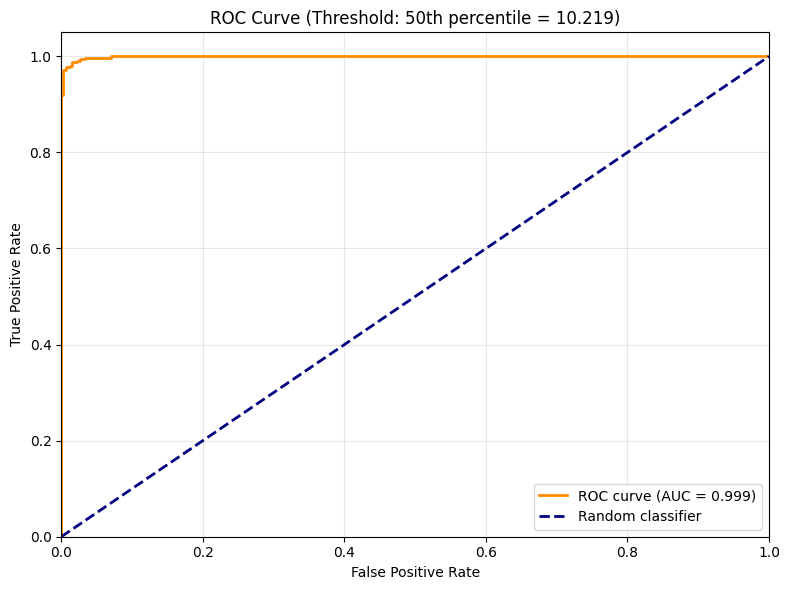

ROC AUC Score: 0.9993
Classification threshold (Speed > 10.219): 50th percentile


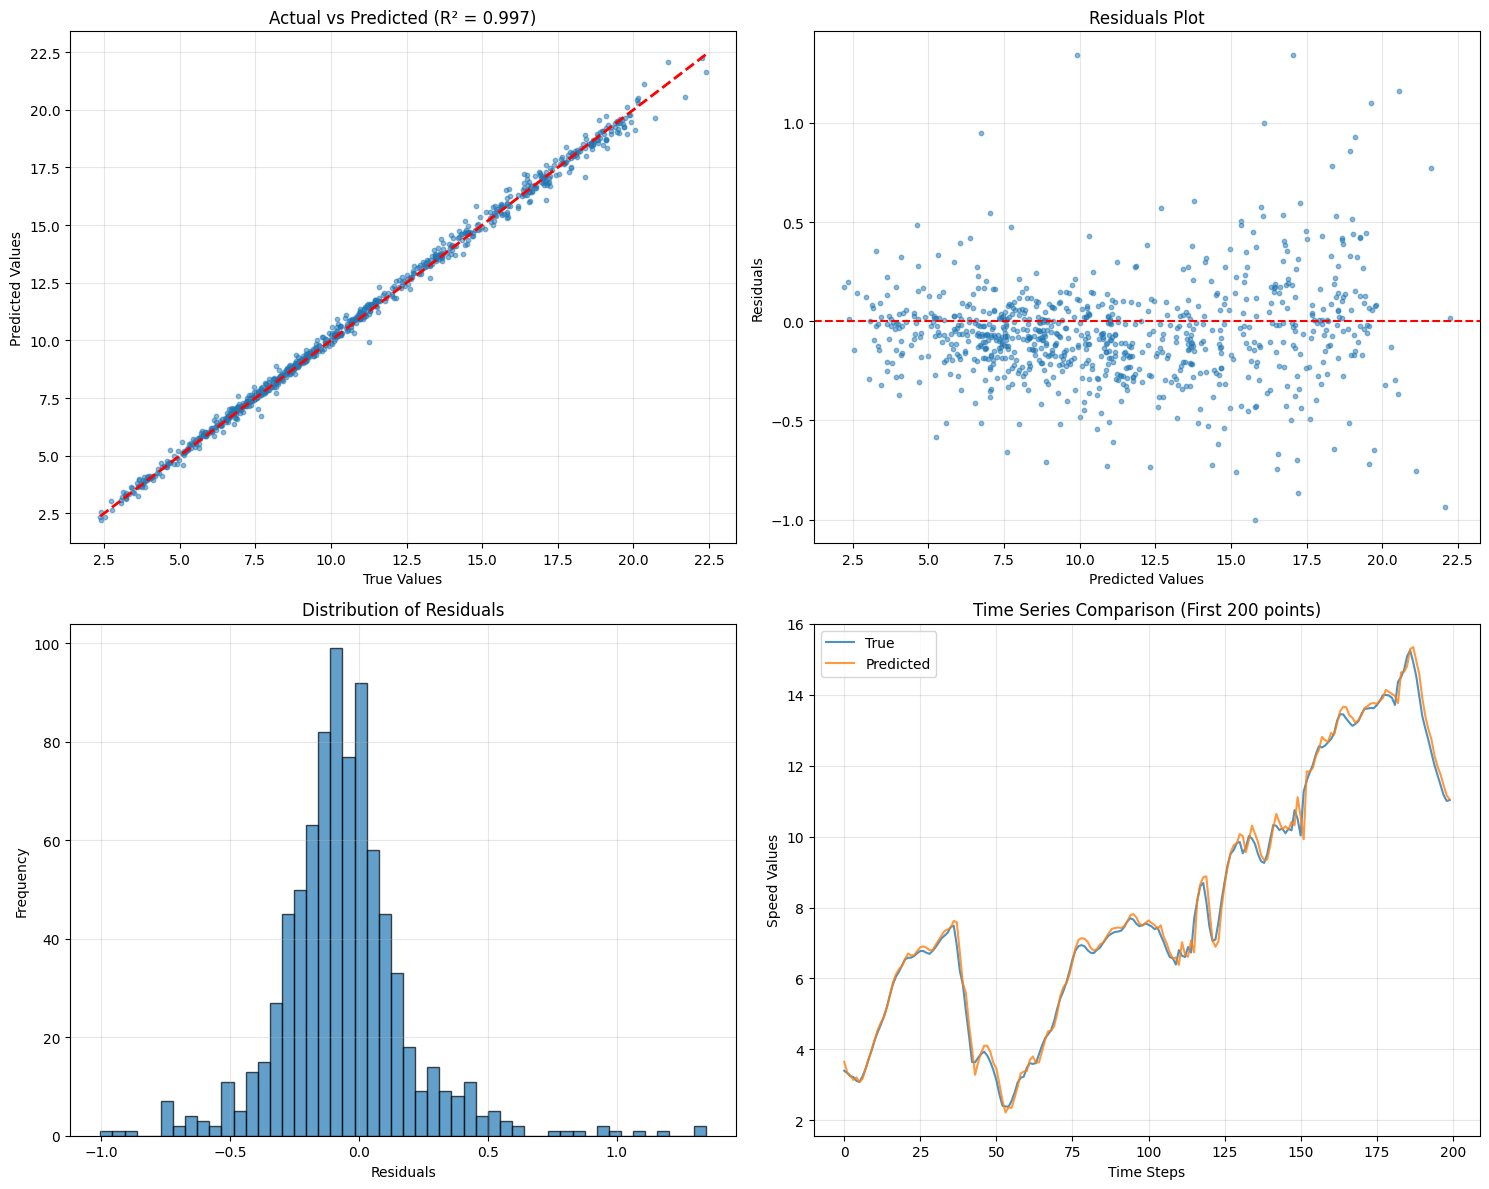


🎯 KEY PERFORMANCE METRICS:
   R² Score: 0.996856
   RMSE: 0.257575
   ROC AUC: 0.9993


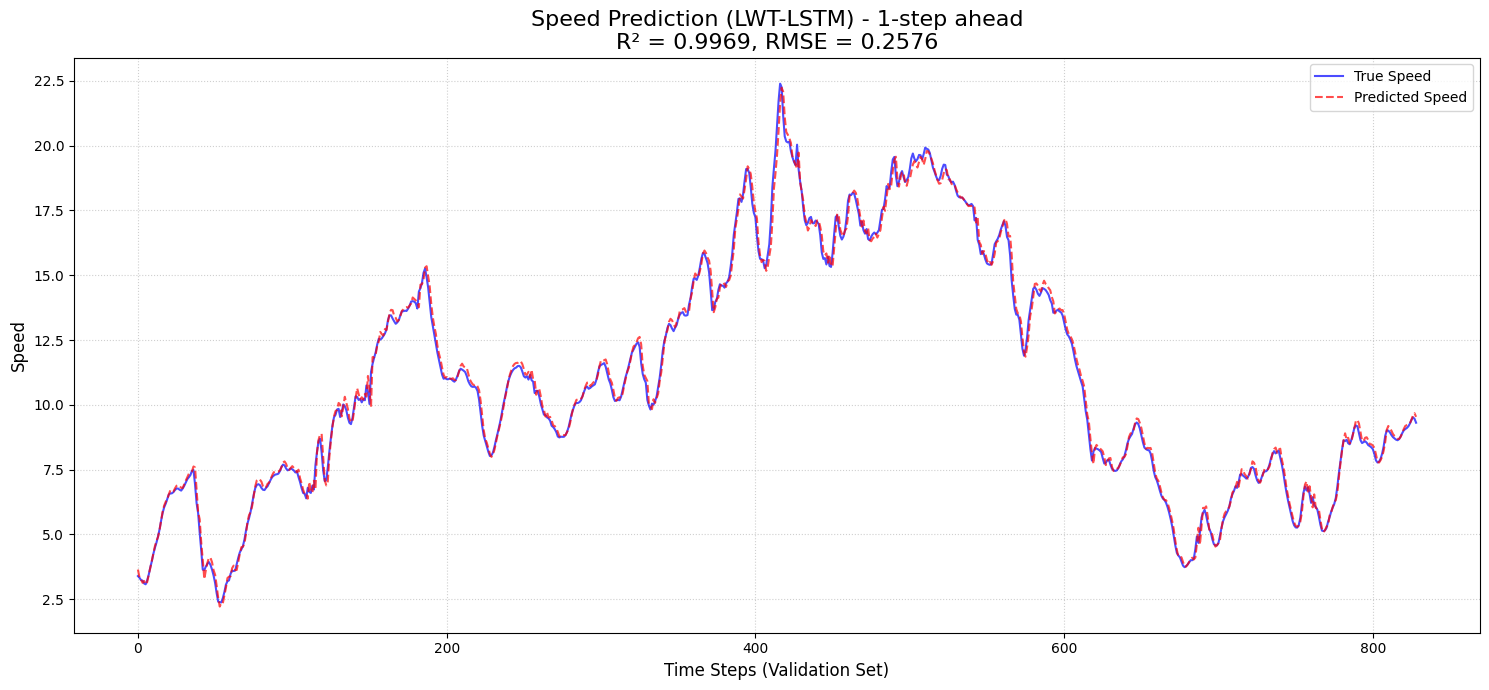


Final Mean Squared Error on Validation Set (Original Scale): 0.066345
Final Mean Absolute Error on Validation Set (Original Scale): 0.182624


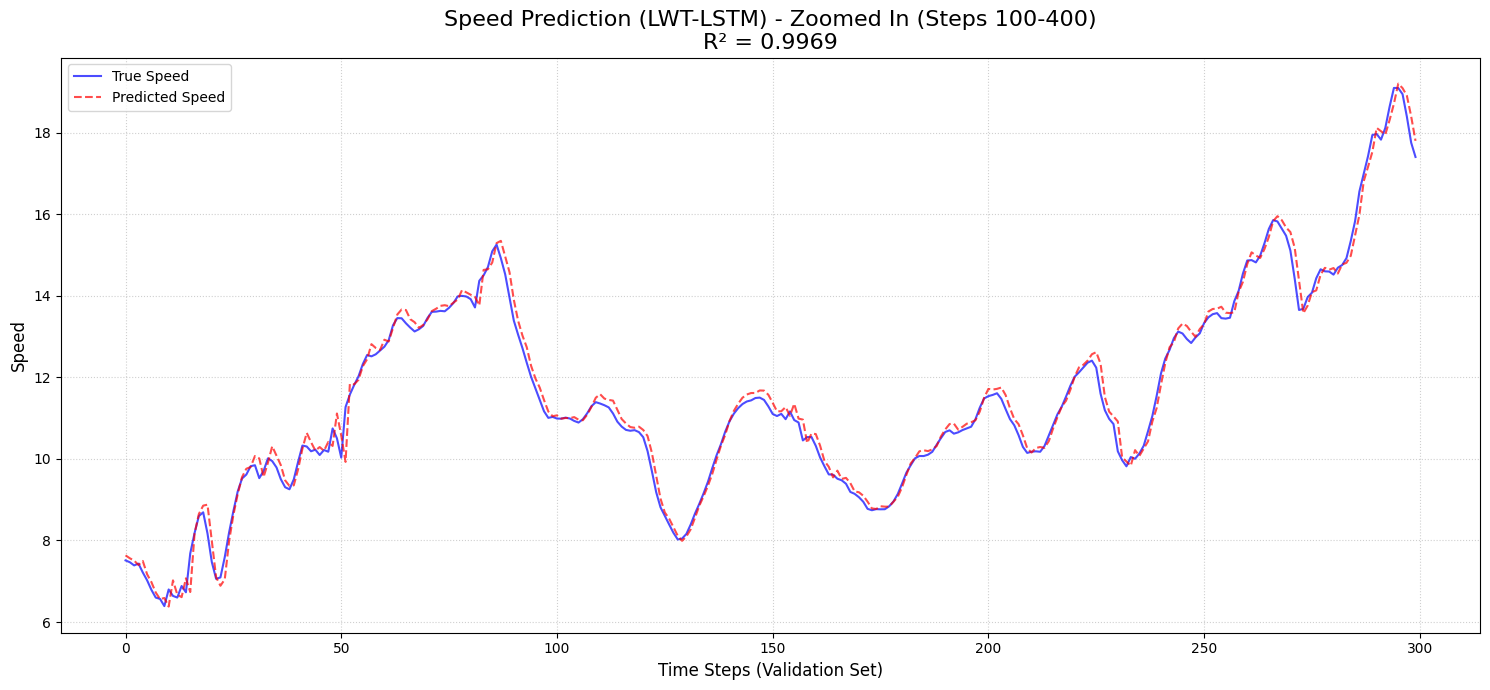


📊 Evaluation summary saved to 'model_evaluation_summary_haar.txt'
🖼️  Plots saved: ROC curve, comprehensive evaluation, and prediction plots


In [8]:
# --- Main Execution ---
if __name__ == "__main__":
    file_path = "Data_August_Renewable.csv"
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please ensure it's uploaded correctly.")
        exit()
    except Exception as e:
        print(f"An error occurred while reading the CSV: {e}")
        exit()

    print("Original DataFrame Head:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()

    if df['Speed'].isnull().any():
        print("\nMissing values found in 'Speed' column. Filling with forward fill.")
        df['Speed'].ffill(inplace=True)

    lwt_window_size = 32
    prediction_horizon = 1
    lwt_levels = 3
    
    # Choose your custom wavelet type here:
    # Supported: 'haar', 'linear_interp'
    # wavelet_type = 'linear_interp'
    wavelet_type = 'haar'

    X_train, y_train, X_val, y_val, scaler = prepare_time_series_data(
        df, 'Speed', lwt_window_size, prediction_horizon
    )

    print(f"\nTraining input sequences shape (LWT window): {X_train.shape}")
    print(f"Training target values shape: {y_train.shape}")
    print(f"Validation input sequences shape (LWT window): {X_val.shape}")
    print(f"Validation target values shape: {y_val.shape}")

    sample_window = X_train[0]
    lwt_util_for_dim_calc = LWT(wavelet_name=wavelet_type)
    approx_sample, details_sample_list, _ = lwt_util_for_dim_calc.transform(sample_window, levels=lwt_levels)

    input_dim_flat = approx_sample.size
    for level_details in details_sample_list:
        for detail_arr in level_details.values():
            input_dim_flat += detail_arr.size
    
    print(f"\nFlattened LWT feature dimension for LSTM input: {input_dim_flat}")

    output_dim_flat = 1 
    print(f"Output dimension for LSTM: {output_dim_flat}")

    hidden_dim = 64
    num_layers = 2
    epochs = 200
    batch_size = 64
    learning_rate = 0.001

    model = LWT_LSTM_Predictor(
        input_dim_flat=input_dim_flat,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim_flat=output_dim_flat,
        lwt_levels=lwt_levels,
        wavelet_name=wavelet_type,
        use_cupy=USE_CUPY # Pass CuPy usage flag to model
    )

    train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate)

    print("\n--- Generating Validation Predictions ---")
    model.eval()
    torch.save(model.state_dict(), f"lwt_lstm_predictor_{wavelet_type}.pth")
    print(f"Model saved as 'lwt_lstm_predictor_{wavelet_type}.pth'")
    predictions_scaled = []
    targets_scaled = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for i in range(0, len(X_val), batch_size):
        batch_input_val_np = X_val[i : i + batch_size]
        batch_target_val_np = y_val[i : i + batch_size]
        
        if len(batch_input_val_np) == 0:
            continue

        # Convert input to CuPy if CuPy is active
        if USE_CUPY:
            batch_input_val = cp.asarray(batch_input_val_np)
        else:
            batch_input_val = batch_input_val_np

        with torch.no_grad():
            predicted_batch_scaled = model(batch_input_val).cpu().numpy() # Always move to CPU for numpy/plotting
        
        predictions_scaled.extend(predicted_batch_scaled.flatten())
        targets_scaled.extend(batch_target_val_np.flatten()) # targets were already NumPy

    predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
    targets_scaled = np.array(targets_scaled).reshape(-1, 1)

    predictions_original = scaler.inverse_transform(predictions_scaled)
    targets_original = scaler.inverse_transform(targets_scaled)

    # === COMPREHENSIVE MODEL EVALUATION WITH ROC CURVE AND R² ===
    print("\n" + "="*60)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*60)
    
    # Perform comprehensive evaluation including ROC curve and R²
    evaluation_results = evaluate_model_comprehensive(
        targets_original, 
        predictions_original, 
        model_name=f"LWT-LSTM ({wavelet_type})"
    )
    
    # Display key metrics prominently
    print(f"\n🎯 KEY PERFORMANCE METRICS:")
    print(f"   R² Score: {evaluation_results['r2_score']:.6f}")
    print(f"   RMSE: {evaluation_results['rmse']:.6f}")
    print(f"   ROC AUC: {evaluation_results['roc_auc']:.4f}")
    
    plt.figure(figsize=(15, 7))
    plt.plot(targets_original, label='True Speed', color='blue', alpha=0.7, linewidth=1.5)
    plt.plot(predictions_original, label='Predicted Speed', color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    plt.title(f'Speed Prediction (LWT-LSTM) - {prediction_horizon}-step ahead\nR² = {evaluation_results["r2_score"]:.4f}, RMSE = {evaluation_results["rmse"]:.4f}', fontsize=16)
    plt.xlabel('Time Steps (Validation Set)', fontsize=12)
    plt.ylabel('Speed', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'speed_prediction_{wavelet_type}_lwt_lstm.png', dpi=300)
    plt.show()

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    final_mse = mean_squared_error(targets_original, predictions_original)
    final_mae = mean_absolute_error(targets_original, predictions_original)
    print(f"\nFinal Mean Squared Error on Validation Set (Original Scale): {final_mse:.6f}")
    print(f"Final Mean Absolute Error on Validation Set (Original Scale): {final_mae:.6f}")

    if len(targets_original) > 500:
        zoom_start = 100
        zoom_end = 400
        plt.figure(figsize=(15, 7))
        plt.plot(targets_original[zoom_start:zoom_end], label='True Speed', color='blue', alpha=0.7, linewidth=1.5)
        plt.plot(predictions_original[zoom_start:zoom_end], label='Predicted Speed', color='red', linestyle='--', alpha=0.7, linewidth=1.5)
        plt.title(f'Speed Prediction (LWT-LSTM) - Zoomed In (Steps {zoom_start}-{zoom_end})\nR² = {evaluation_results["r2_score"]:.4f}', fontsize=16)
        plt.xlabel('Time Steps (Validation Set)', fontsize=12)
        plt.ylabel('Speed', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout()
        plt.savefig(f'speed_prediction_zoomed_{wavelet_type}_lwt_lstm.png', dpi=300)
        plt.show()

    # Save evaluation results to file
    results_summary = f"""
LWT-LSTM Model Evaluation Summary ({wavelet_type} wavelet)
================================================
R² Score: {evaluation_results['r2_score']:.6f}
Mean Squared Error (MSE): {evaluation_results['mse']:.6f}
Root Mean Squared Error (RMSE): {evaluation_results['rmse']:.6f}
Mean Absolute Error (MAE): {evaluation_results['mae']:.6f}
Mean Absolute Percentage Error (MAPE): {evaluation_results['mape']:.3f}%
ROC AUC Score: {evaluation_results['roc_auc']:.4f}
Classification Threshold: {evaluation_results['classification_threshold']:.3f}

Model Configuration:
- LWT Window Size: {lwt_window_size}
- LWT Levels: {lwt_levels}
- Wavelet Type: {wavelet_type}
- Hidden Dimensions: {hidden_dim}
- Number of Layers: {num_layers}
- Epochs: {epochs}
- Batch Size: {batch_size}
- Learning Rate: {learning_rate}
- Using CuPy: {USE_CUPY}
"""
    
    with open(f'model_evaluation_summary_{wavelet_type}.txt', 'w') as f:
        f.write(results_summary)
    
    print(f"\n📊 Evaluation summary saved to 'model_evaluation_summary_{wavelet_type}.txt'")
    print(f"🖼️  Plots saved: ROC curve, comprehensive evaluation, and prediction plots")